In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')

In [3]:
temp_celcius = np.array([0.5, 14., 15., 28., 11., 8., 3., -4., 6., 13., 21.]).reshape(-1, 1)
temp_units = np.array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]).reshape(-1, 1)

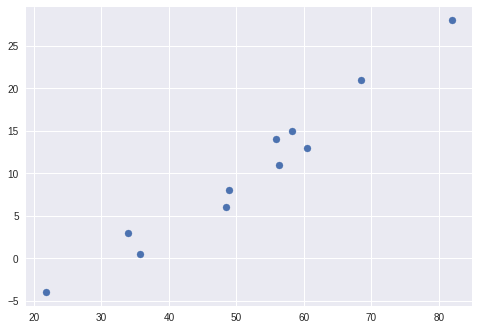

In [4]:
plt.scatter(temp_units, temp_celcius)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# Scale
scaler_temp_units = StandardScaler()
scaler_temp_units.fit(temp_units)
temp_units_scaled = scaler_temp_units.transform(temp_units)

scaler_temp_celcius = StandardScaler()
scaler_temp_celcius.fit(temp_celcius)
temp_celcius_scaled = scaler_temp_celcius.transform(temp_celcius)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(temp_units_scaled, 
                                                  temp_celcius_scaled, 
                                                  test_size=0.2)

## **Pytorch**

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

In [9]:
class TempDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.float32)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [10]:
valset = TempDataset(x_val, y_val)
trainset = TempDataset(x_train, y_train)

In [12]:
datasets = { 'val': valset,
             'train': trainset }

In [13]:
# Network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(1, 13)
        self.fc2 = nn.Linear(13, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)

        return x

In [14]:
class RunningMetric():
    def __init__(self):
        self.S = 0
        self.N = 0

    def update(self, val, size):
        self.S += val
        self.N += size

    def __call__(self):
        return self.S / float(self.N)

In [15]:
import time
from IPython.display import clear_output

In [16]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [17]:
def train_and_evaluate(model, optimizer, loss_fn, datasets, num_epoch=10, lr=0.001):

    losses_train = []
    losses_val = []

    for g in optimizer.param_groups:
        g['lr'] = lr

    for epoch in range(num_epoch):
        running_loss_train = RunningMetric()
        running_loss_val = RunningMetric()

        for phase in ['train', 'val']:
            for inputs, targets in datasets[f'{phase}']:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                    batch_size = inputs.size()[0]

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        running_loss_train.update(loss.item() * batch_size, batch_size)
                    
                    else:
                        running_loss_val.update(loss.item() * batch_size, batch_size)

        # Plot
        if epoch % 50 == 0:
            losses_train.append( running_loss_train() )
            losses_val.append( running_loss_val() )
            
            plt.plot(range(len(losses_train)), losses_train, color='purple')
            plt.plot(range(len(losses_val)), losses_val)
            plt.show()

            print('Loss train: {}  Loss val: {}'.format(running_loss_train(), 
                                                        running_loss_val() ))

            clear_output(wait=True)
            time.sleep(0.5)


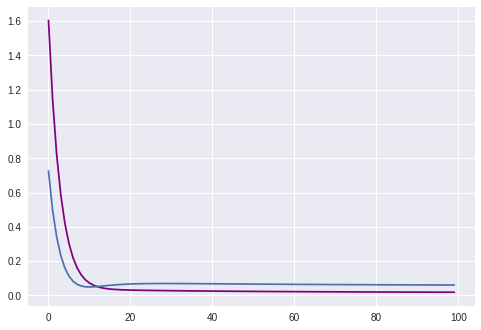

Loss train: 0.01840001344680786  Loss val: 0.0602165125310421


In [18]:
train_and_evaluate(model, optimizer, loss_fn, datasets, num_epoch=5000)

In [21]:
temp_range = scaler_temp_units.transform(np.arange(20., 90.).reshape(-1, 1))

# Rescale inputs
_temp_range = torch.from_numpy(temp_range).type(torch.float32)
model_range = model(_temp_range).detach().numpy()

_temp_units_scaled = torch.from_numpy(temp_units_scaled).type(torch.float32)
model_celcius = model(_temp_units_scaled).detach().numpy()

# Rescale predicts
model_range = scaler_temp_celcius.inverse_transform(model_range)
model_celcius = scaler_temp_celcius.inverse_transform(model_celcius)

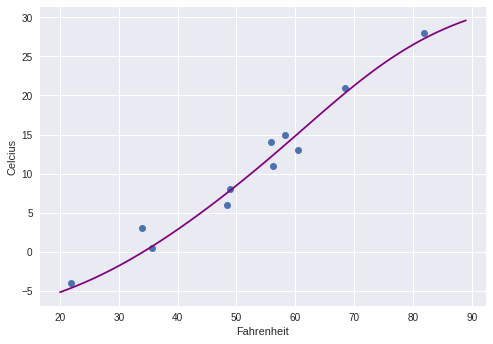

In [22]:
plt.xlabel('Fahrenheit')
plt.ylabel('Celcius')

plt.plot(temp_units, temp_celcius, 'o')
plt.plot(scaler_temp_units.inverse_transform(temp_range), model_range, 'c-', color='purple')
# plt.plot(temp_units, model_celcius, 'kx', color='red')
plt.show()
